In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh
from discretize.utils import ndgrid, mkvc

import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps, data, data_misfit as dm, inverse_problem, regularization as reglib, optimization, directives, inversion

from skimage.metrics import structural_similarity as ssim

mpl.rcParams.update({"font.size": 14})


In [3]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf


In [ ]:


os.chdir('..')
loaded_model = tf.keras.models.load_model('./model_train/reg_model.h5',)
mask_model = tf.keras.models.load_model('./model_train/imaging_model.h5')




In [4]:

rho_true = np.load("case.npy")
rho0 = np.load("model44.npy")
rho1 = np.load("model33.npy")
rho2 = np.load("model22.npy")
rho3 = np.load("model111.npy")

rho4 = mask_model((rho3)[np.newaxis, ..., np.newaxis]).numpy().squeeze()


rho3.shape

NameError: name 'mask_model' is not defined

mesh_lci shape: nCx = 24 , nCz = 32


TensorMesh: 768 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     24        -12.00         12.00      1.00      1.00    1.00
   y     32       -620.54         -0.00      4.54     47.28    1.08

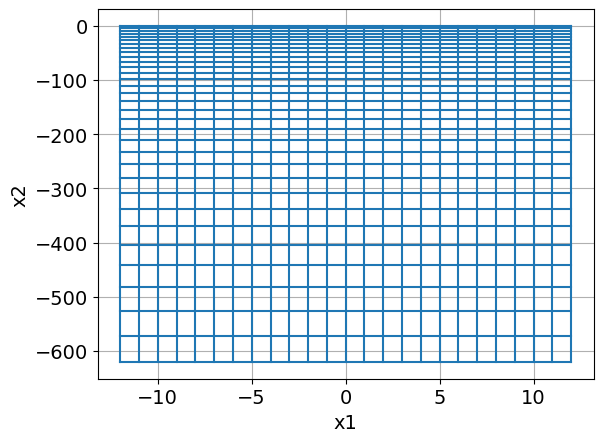

In [5]:

# 1) Layer thicknesses and grid (L layers; half-space is completed by mapping)
class DummyForGrid:
    def __init__(self, ny):
        self.ny = ny
        # Uniformly spaced depth boundaries from 0 to 600 m, for ny layers
        self.y_uniform = np.linspace(0, 600, ny + 1)
    
    def create_log_depth_grid(self, z0=1.0, exponent=2.5):
        """
        Create logarithmically spaced depth centers given a base and exponent.
        """
        y_max = self.y_uniform[-1]
        i = np.linspace(0, 1, self.ny + 1)
        z_edges = z0 * (np.exp(exponent * i) - 1)
        z_edges = z_edges / z_edges[-1] * y_max  # Normalize max edge to y_max
        z_centers = (z_edges[:-1] + z_edges[1:]) / 2
        return z_centers

res_layer = 32
dummy = DummyForGrid(res_layer)
depths = dummy.create_log_depth_grid(z0=1.0, exponent=2.5)

# depths = np.geomspace(1.0, 150.0, res_layer)  # Option: geometric (log) spacing

# Calculate thicknesses between depth centers, last thickness is repeated
thicknesses = np.r_[np.diff(depths), np.diff(depths)[-1]]

hx = np.ones(24)  # Uniform grid in x-direction
hz = np.r_[thicknesses]  # Thicknesses in z-direction

hz = np.flipud(hz)  # Flip so that shallowest is first

mesh_lci = TensorMesh([hx, hz], "CN")  # Tensor mesh with specified cell widths
reg_map_lci = maps.IdentityMap(nP=mesh_lci.nC)  # Regularization mapping
mesh_lci.plot_grid()  # Plot the mesh grid

print("mesh_lci shape: nCx =", mesh_lci.shape_cells[0], ", nCz =", mesh_lci.shape_cells[1])
mesh_lci

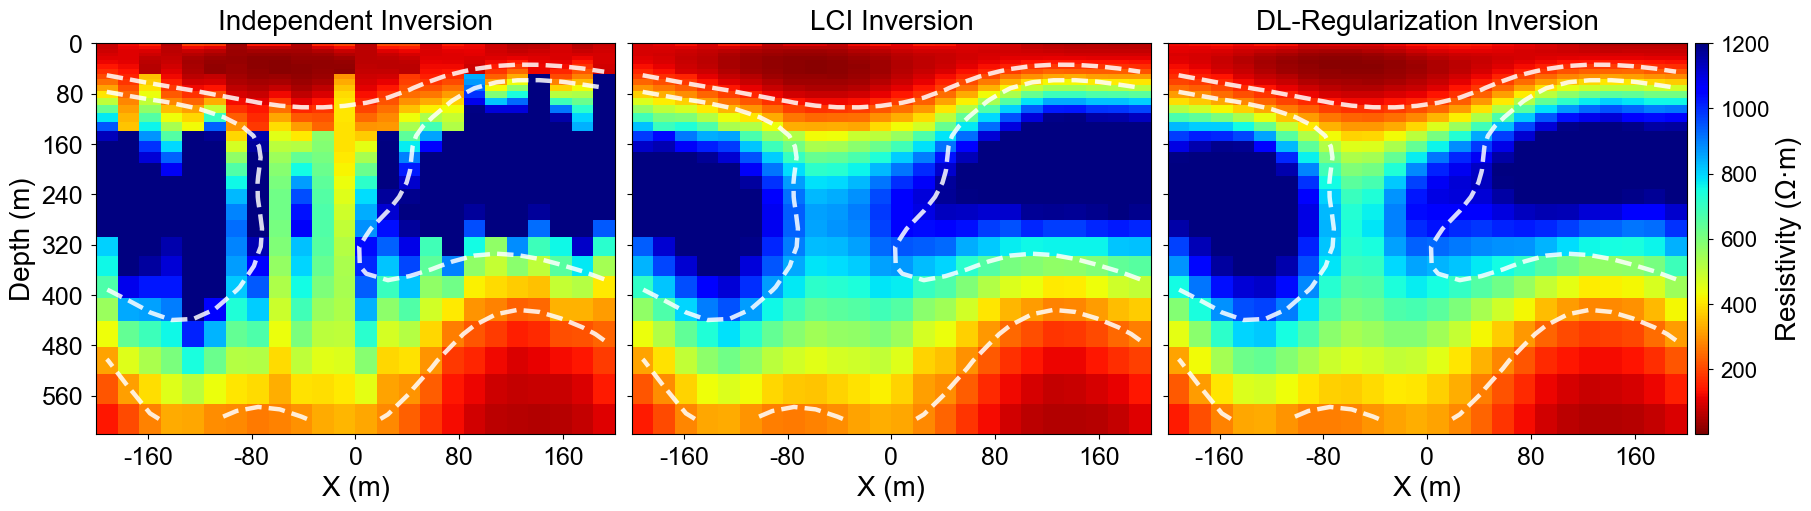

In [ ]:
import skimage.measure as measure
import matplotlib.ticker as ticker

# Use a visually appealing style for the plots
plt.style.use('seaborn-v0_8-paper')

# Define the coordinate range for the X axis
y_coords = np.linspace(-200, 200, 24)

# Layer interfaces, from shallow to deep; reversed because hz[::-1] gives top-to-bottom
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))
# pcolormesh grid requires the definition via grid edges
y_edges = np.linspace(y_coords[0], y_coords[-1], len(y_coords) + 1)
z_edges = layer_interfaces  # use layer interfaces as z (depth) edges

rho_list = [rho1, rho2, rho3, rho4]
titles = [
    "Independent Inversion", 
    "LCI Inversion", 
    "DL-Regularization Inversion", 
    "Boundary-SR Inversion"
]

# Create a figure with 1 row and 3 columns; share y axis
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True, sharey=True)

# Set a unified colorbar range based on the minimum and maximum values of all model results
vmin = 1
vmax = 1200

vmin_cb = vmin
vmax_cb = vmax

# Compute the boundary contours in the true resistivity model, and map to real-world coordinates
# Mapping is done using the centers of the pcolormesh grid
x_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

# Select contour levels; here, two levels at 700 and 300 (can be modified as needed)
contour_level1 = 700
contours1 = measure.find_contours(np.abs(rho_true.T), contour_level1)  # extract contours in index space
contour_level2 = 300
contours2 = measure.find_contours(np.abs(rho_true.T), contour_level2)
contours = contours1 + contours2
# Map contour coordinates, originally in index space, to the physical coordinate system
mapped_contours = []
nz, nx = rho_true.T.shape
xi = np.arange(nx)
zi = np.arange(nz)
for c in contours:
    # Each contour is an (N, 2) array: columns are (row=z_idx, col=x_idx)
    z_idx = c[:, 0]
    x_idx = c[:, 1]
    x_vals = np.interp(x_idx, xi, x_centers)
    z_vals = np.interp(z_idx, zi, z_centers)
    mapped_contours.append((x_vals, z_vals))

for i, (rho, ax, title) in enumerate(zip(rho_list, axes, titles)):
    # pcolormesh expects grid edges and an array of shape (ny, nz)
    quad = ax.pcolormesh(
        y_edges, 
        z_edges, 
        np.abs(rho.T),         # rho shape (nx, nz); .T gives (nz, nx), as required for pcolormesh(y, z, arr)
        cmap="jet_r",
        shading='auto',        # 'auto' selects proper shading for a given input
        vmin=vmin_cb, vmax=vmax_cb
    )

    # For the first plot, contour is highlighted in white outline; for others, the same contour is overlaid for comparison
    for x_vals, z_vals in mapped_contours:
        ax.plot(x_vals, z_vals, color='white', linewidth=3.2, alpha=0.85, zorder=4, linestyle='--')
        # Uncomment to add main contour in black:
        # ax.plot(x_vals, z_vals, color='k', linewidth=2.5, alpha=1, zorder=5, linestyle='-')

    ax.set_xlabel("X (m)", fontsize=20)
    if i == 0:
        ax.set_ylabel("Depth (m)", fontsize=20)
    ax.set_title(title, fontsize=20, pad=10)
    ax.set_xlim(y_coords[0], y_coords[-1])
    ax.set_ylim(z_edges[0], z_edges[-1])
    # Beautify tick marks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.invert_yaxis()

# Shared colorbar (independent of each ax, for the complete row of subplots)
cbar = fig.colorbar(quad, ax=axes, orientation='vertical', fraction=0.02, pad=0.005, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.savefig("./figure/comparison_figure.png", dpi=400, bbox_inches='tight')
plt.show()

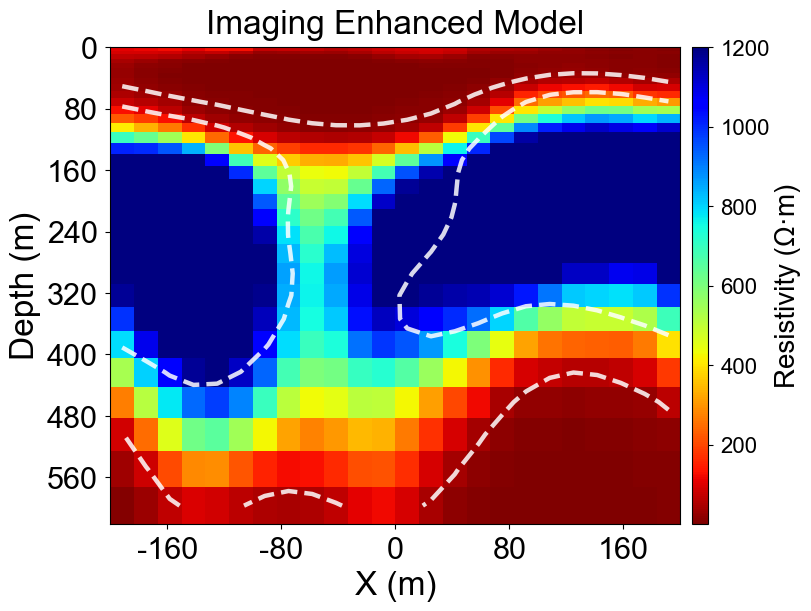

In [ ]:
# Plot only one true model (rho_true)

import skimage.measure as measure
import matplotlib.ticker as ticker

plt.style.use('seaborn-v0_8-paper')

# Define coordinate ranges
y_coords = np.linspace(-200, 200, 24)
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))  # hz[::-1]: from shallow to deep
y_edges = np.linspace(y_coords[0], y_coords[-1], len(y_coords) + 1)
z_edges = layer_interfaces

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# Set colorbar range using vmin/vmax for consistency
vmin = 1
vmax = 1200

# Calculate contours for model boundary visualization
x_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

contour_level1 = 700
contours1 = measure.find_contours(np.abs(rho_true.T), contour_level1)
contour_level2 = 300
contours2 = measure.find_contours(np.abs(rho_true.T), contour_level2)
contours = contours1 + contours2

tx_x_positions = y_coords  # One transmitter at each grid point along y direction (customize if needed)
tx_y_position = -18  # All transmitters have a y-coordinate of -18

# Map contour points from index space to physical coordinates
nz, nx = rho_true.T.shape
xi = np.arange(nx)
zi = np.arange(nz)
mapped_contours = []
for c in contours:
    z_idx = c[:, 0]
    x_idx = c[:, 1]
    x_vals = np.interp(x_idx, xi, x_centers)
    z_vals = np.interp(z_idx, zi, z_centers)
    mapped_contours.append((x_vals, z_vals))

# pcolormesh expects grid edges and (ny, nz) matrix
mesh = ax.pcolormesh(
    y_edges,
    z_edges,
    np.abs(rho4.T),
    cmap="jet_r",
    shading='auto',
    vmin=vmin,
    vmax=vmax
)

# Plot model contours
for x_vals, z_vals in mapped_contours:
    ax.plot(x_vals, z_vals, color='white', linewidth=3.2, alpha=0.85, zorder=4, linestyle='--')  # Highlighted white outline
    # ax.plot(x_vals, z_vals, color='k', linewidth=2.5, alpha=1, zorder=5, linestyle='-')        # Main contour in black

ax.set_xlabel("X (m)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)
ax.set_xticks([-200, -120, -60, 0, 60, 120, 200])
ax.set_ylim(0, z_edges[-1])
# Beautify tick marks
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax.tick_params(axis='both', which='major', labelsize=22)
ax.invert_yaxis()
# Add title
ax.set_title("Imaging Enhanced Model", fontsize=24, pad=10)

# Add standalone colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.04, pad=0.02, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.savefig("./figure/imaging_enhanced_inversion.png", dpi=400, bbox_inches='tight')

plt.show()


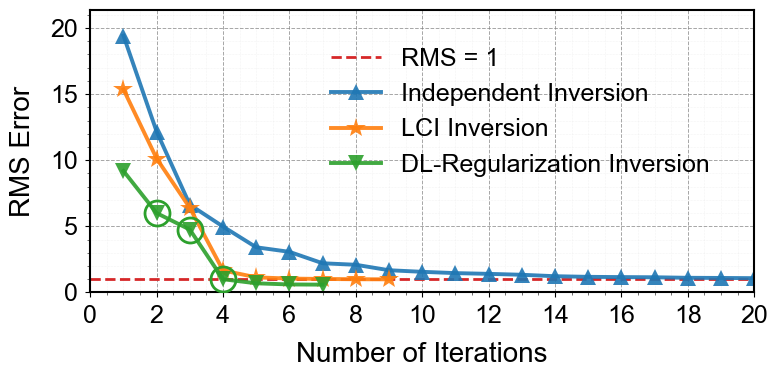

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set font for displaying English (or Chinese, if needed)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# Load RMS data from files (expects .npy format)
RMS1 = np.load('RMS33.npy')
RMS2 = np.load('RMS22.npy')
RMS3 = np.load('RMS11.npy')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Use a professional color palette for lines
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot horizontal reference line at RMS=1
ax.axhline(y=1, color='#d62728', linestyle='--', linewidth=2, label='RMS = 1 ')

# Plot RMS curves with markers and styles
line0 = ax.plot(range(1, len(RMS1)+1), RMS1, label='Independent Inversion ', linewidth=2.8, color=colors[0],
                marker='^', markersize=12, alpha=0.9)[0]
line2 = ax.plot(range(1, len(RMS2)+1), RMS2, label='LCI Inversion ', linewidth=2.8, color=colors[1],
                marker='*', markersize=15, alpha=0.9)[0]
line3 = ax.plot(range(1, len(RMS3)+1), RMS3, label='DL-Regularization Inversion ', linewidth=2.8, color=colors[2],
                marker='v', markersize=12,  alpha=0.9)[0]

# Annotate the 2nd, 3rd, and 4th data points in line3 (indexing from 0)
for i in [1, 2, 3]:
    ax.plot(i+1, RMS3[i], marker='o', markersize=18, markerfacecolor='none',
            markeredgecolor='#2ca02c', markeredgewidth=2, zorder=10)

# Axis labels and title
ax.set_xlabel('Number of Iterations', fontsize=20, fontweight='medium', labelpad=10)
ax.set_ylabel('RMS Error', fontsize=20, fontweight='medium', labelpad=10)

# Configure legend at the best location, no frame or shadow
legend = ax.legend(fontsize=18, frameon=False, fancybox=False, shadow=False, 
                  framealpha=0.95, edgecolor='black', loc='best',
                  borderpad=1, handlelength=2)

# Grid styling for clarity
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7, color='gray')
ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, color='lightgray')
ax.minorticks_on()

# Set axis limits to provide margin
ax.set_xlim(0, int(len(RMS1)))
ax.set_ylim(0, max(max(RMS1), max(RMS2), max(RMS3)) * 1.1)

# Set x-axis ticks to multiples of 2, show as integer
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

max_iter = int(len(RMS1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Set axis tick font size
ax.tick_params(axis='both', which='major', labelsize=18)

# Set border (spine) properties
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("./figure/RMS_Comparison.png", dpi=400, bbox_inches='tight')

# Show the plot
plt.show()

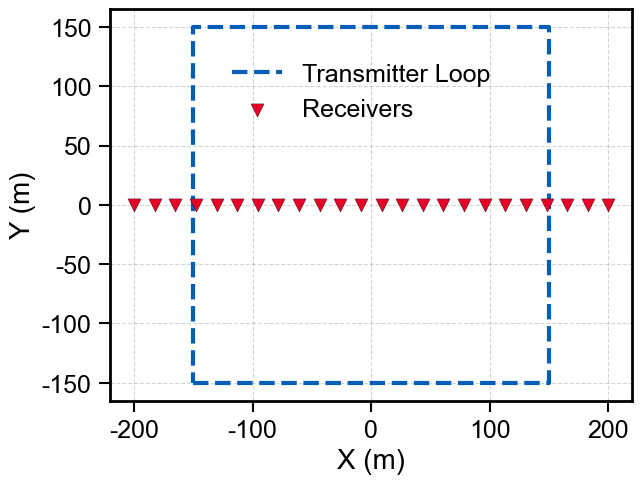

In [ ]:

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False  # Display minus sign properly

time_channels = np.logspace(-5, -2, 20)

# X-direction receiver points (can adjust range and step as needed)
receiver_locations = ndgrid(
    np.linspace(-200, 200, 24),
    np.array(0),
    [0]
)

# Transmitter loop (example rectangle)
xyz_loop = np.array([
    [-150, -150, 0], [0, -150, 0], [150, -150, 0], [150, 0, 0],
    [150, 150, 0], [0, 150, 0], [-150, 150, 0], [-150, 0, 0], [-150, -150, 0]
])

# Beautiful plot of transmitter and receiver layout
fig, ax = plt.subplots(figsize=(7, 7))
xyz_loop_forplot = np.vstack([xyz_loop, xyz_loop[0]])  # Close the loop

# Plot transmitter loop
ax.plot(
    xyz_loop_forplot[:, 0], xyz_loop_forplot[:, 1],
    color="#005eb8", marker="o", markersize=0, linewidth=3,
    linestyle='--',
    label="Transmitter Loop"
)

# Plot receiver points
ax.scatter(
    receiver_locations[:, 0], receiver_locations[:, 1],
    c="#e60026", edgecolor="k", s=90, marker="v", label="Receivers", zorder=5
)

# Set tick parameters
ax.xaxis.set_tick_params(labelsize=18, length=8, width=1.5)
ax.yaxis.set_tick_params(labelsize=18, length=8, width=1.5)

ax.set_xlabel("X (m)", fontsize=20, fontname='Arial')
ax.set_ylabel("Y (m)", fontsize=20, fontname='Arial')

ax.legend(fontsize=18, frameon=False, shadow=False,  bbox_to_anchor=(0.48, 0.92), ncol=1)
ax.grid(True, which="both", ls="--", color="#888888", alpha=0.35)

# Set all tick labels to Arial font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')

# Adjust border order and thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set border thickness to 2

# Improve display quality and layout
ax.set_aspect('equal', 'box')
fig.tight_layout(pad=2.0)
plt.savefig("./figure/observation_layout.png", dpi=400, bbox_inches='tight')

plt.show()


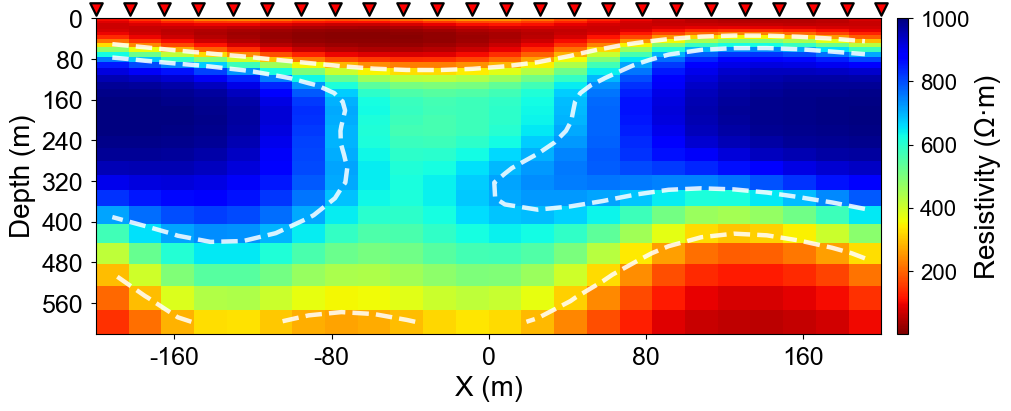

In [ ]:
# Plot only the true model (rho_true)

import skimage.measure as measure
import matplotlib.ticker as ticker

plt.style.use('seaborn-v0_8-paper')

# Coordinate range
y_coords = np.linspace(-200, 200, 24)
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))  # hz[::-1]: from shallow to deep
y_edges = np.linspace(y_coords[0], y_coords[-1], len(y_coords) + 1)
z_edges = layer_interfaces

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

# Colorbar range, use vmin/vmax to set limits
vmin = 1
vmax = 1000

# Calculate contours for model boundary visualization
x_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

contour_level1 = 700
contours1 = measure.find_contours(np.abs(rho_true.T), contour_level1)
contour_level2 = 300
contours2 = measure.find_contours(np.abs(rho_true.T), contour_level2)
contours = contours1 + contours2

tx_x_positions = y_coords  # A transmitter at each grid point in y direction (customize if needed)
tx_y_position = -18  # All transmitter y-coordinates are -18

# Plot transmitters (ensure they are visible and not clipped)
ax.scatter(
    tx_x_positions,
    np.full_like(tx_x_positions, tx_y_position),
    c='red', marker='v', s=80, edgecolors='black', linewidths=1.6, label='Transmitter',
    zorder=15,       # High zorder ensures on top
    clip_on=False    # Important: not clipped by pcolormesh
)

# Map contour indices to physical coordinates
nz, nx = rho_true.T.shape
xi = np.arange(nx)
zi = np.arange(nz)
mapped_contours = []
for c in contours:
    z_idx = c[:, 0]
    x_idx = c[:, 1]
    x_vals = np.interp(x_idx, xi, x_centers)
    z_vals = np.interp(z_idx, zi, z_centers)
    mapped_contours.append((x_vals, z_vals))

# pcolormesh expects grid edges and matrix of shape (ny, nz)
mesh = ax.pcolormesh(
    y_edges,
    z_edges,
    np.abs(rho_true.T),
    cmap="jet_r",
    shading='auto',
    vmin=vmin,
    vmax=vmax
)

# Plot model contours
for x_vals, z_vals in mapped_contours:
    ax.plot(x_vals, z_vals, color='white', linewidth=3.2, alpha=0.85, zorder=4, linestyle='--')  # White highlight
    # ax.plot(x_vals, z_vals, color='k', linewidth=2.5, alpha=1, zorder=5, linestyle='-')        # Black main border

ax.set_xlabel("X (m)", fontsize=20)
ax.set_ylabel("Depth (m)", fontsize=20)
ax.set_xticks([-200, -120, -60, 0, 60, 120, 200])
ax.set_ylim(0, z_edges[-1])
# Beautify major tick marks
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.invert_yaxis()

# Separate colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)
cbar.set_label("Resistivity (Ω·m)", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.savefig("./figure/simulation_model.png", dpi=400, bbox_inches='tight')

plt.show()
